In [1]:
import numpy as np

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C
import matplotlib.pyplot as plt

from copy import deepcopy as copy
# np.random.seed(1)

In [2]:
!pip install git+https://github.com/kilean20/pyTorchTemplate.git

Defaulting to user installation because normal site-packages is not writeable
  Cloning https://github.com/kilean20/pyTorchTemplate.git to /tmp/pip-req-build-cs56jfup
  Running command git clone -q https://github.com/kilean20/pyTorchTemplate.git /tmp/pip-req-build-cs56jfup
  Created wheel for pyTorchTemplate: filename=pyTorchTemplate-0.0.1-py3-none-any.whl size=6602 sha256=be88251a58169e7009b226b9b48f093edfb6c6d132e08c7684130a0e04bdd944
  Stored in directory: /tmp/pip-ephem-wheel-cache-lxh0030n/wheels/15/b3/6d/10ca0e96789eddf8cbd29d87914215e75608e6930926678261
Successfully built pyTorchTemplate


In [3]:
!pip install git+https://github.com/kilean20/pyTorchTemplate.git --upgrade

Defaulting to user installation because normal site-packages is not writeable
  Cloning https://github.com/kilean20/pyTorchTemplate.git to /tmp/pip-req-build-sfb0lnjl
  Running command git clone -q https://github.com/kilean20/pyTorchTemplate.git /tmp/pip-req-build-sfb0lnjl
  Created wheel for pyTorchTemplate: filename=pyTorchTemplate-0.0.1-py3-none-any.whl size=6602 sha256=ce26863a9eab258043cecbdcee2857cdbf2a44f3513d16fe155bf067b30c819e
  Stored in directory: /tmp/pip-ephem-wheel-cache-sw12z7x6/wheels/15/b3/6d/10ca0e96789eddf8cbd29d87914215e75608e6930926678261
Successfully built pyTorchTemplate
  Attempting uninstall: pyTorchTemplate
    Found existing installation: pyTorchTemplate 0.0.1
    Uninstalling pyTorchTemplate-0.0.1:
      Successfully uninstalled pyTorchTemplate-0.0.1


In [4]:
import torch
from torch.nn import functional as F
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

import pyTorchTemplate as ptt

In [5]:
print(ptt.__file__)

/global/homes/k/khwang/.local/cori/pytorchv1.4.0/lib/python3.7/site-packages/pyTorchTemplate/__init__.py


$$
\begin{eqnarray}
\boldsymbol{R} &=& |\boldsymbol{x}| \\
{f} &=& \frac{\sin(4\pi \boldsymbol{R})}{4\pi\boldsymbol{R}}
\end{eqnarray}
$$

In [6]:
ndim = 6
nSample = 2048
p = 12

In [7]:
def f(x):
    """The function to predict."""
    
    R = np.sqrt(np.sum(x**2,axis=1)) + 0.0001
    return np.sin(4*np.pi*R)/(4*np.pi*R)

# Prepare data

In [8]:
x_train = ((np.random.rand(nSample,ndim)-0.5)*2).astype(np.float32)
y_train = f(x_train).reshape(-1,1).astype(np.float32)

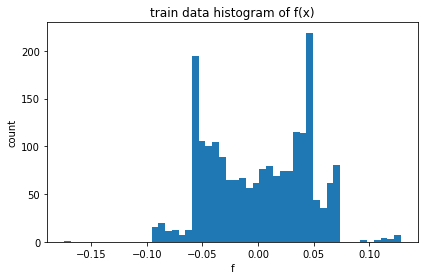

In [9]:
plt.hist(y_train,bins=50);
plt.xlabel('f')
plt.ylabel('count')
plt.title('train data histogram of f(x)')
plt.tight_layout()
plt.savefig('train_data_histo_'+str(ndim)+'D_'+str(nSample)+'sample.png',dpi=180)

In [10]:
x_test = ((np.random.rand(65536,ndim)-0.5)*2).astype(np.float32)
y_test = f(x_test).reshape(-1,1).astype(np.float32)

In [11]:
x_onAxis = np.zeros([256,ndim]).astype(np.float32)
x_onAxis[:,0] = np.linspace(-1, 1, 256)
y_onAxis = f(x_onAxis).reshape(-1,1).astype(np.float32)

In [12]:
train_data_loader = torch.utils.data.DataLoader(list(zip(x_train,y_train)),batch_size=128)
test_data_loader = torch.utils.data.DataLoader(list(zip(x_test,y_test)),batch_size=128)

### GP w/o dim-reduction

In [13]:
kernel = C(0.2, (1e-2, 1e2)) * RBF(1, (2e-2, 1e2))
gpNaive = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=9)

In [14]:
gpNaive.score(x_train, y_train), gpNaive.score(x_test, y_test)

(-0.0007719830981252063, -7.479945886368355e-05)

In [15]:
gpNaive.fit(x_train, y_train)
gpNaive.kernel_

0.1**2 * RBF(length_scale=0.352)

In [16]:
gpNaive.score(x_train, y_train), gpNaive.score(x_test, y_test)   #(0.9999999999999998, 0.2938582961152787)

(0.9999999999999989, -0.48773731467818626)

In [17]:
y_onAxis_GPnaive, sigma_GPnaive = gpNaive.predict(x_onAxis, return_std=True)
y_onAxis_GPnaive = y_onAxis_GPnaive.reshape(-1)

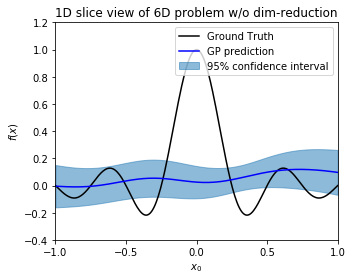

In [18]:
fig = plt.figure(figsize=(5,4))

plt.plot(x_onAxis[:,0],y_onAxis ,'k' , label='Ground Truth')
plt.plot(x_onAxis[:,0],y_onAxis_GPnaive, 'b-', label='GP prediction')
plt.fill_between(x_onAxis[:,0], 
                y_onAxis_GPnaive- 1.96 * sigma_GPnaive,
                y_onAxis_GPnaive+ 1.96 * sigma_GPnaive, 
                label='95% confidence interval', color='C0', alpha=.5, )
# plt.plot(x_onAxis[:,0],y_onAxis_NN, 'r-', label='NN prediction',lw=2,alpha=0.5)

plt.title('1D slice view of '+str(ndim)+'D problem w/o dim-reduction')
plt.xlabel(r'$x_0$')
plt.ylabel(r'$f(x)$')
plt.legend(loc='upper right')
plt.xlim(-1,1)
plt.ylim(-0.4,1.2)
plt.xticks([-1,-0.5,0,0.5,1])
plt.tight_layout()
plt.savefig('GP_woDimReduct_'+str(ndim)+'D.png',dpi=180)

# with DimReduction

### AutoEncoderLike NN

In [19]:
def test(model,criterion,test_data_loader):
  model.eval()
  loss = 0 
  for x, y in test_data_loader:
    x = x.to(device)
    y_pred = model(x)
    loss += criterion(y_pred, y.to(device)).item()
  return loss/len(test_data_loader)

### 2D source

In [20]:
nsource = 2

In [21]:
old_best_loss = 1
for i in range(10):
  model = ptt.resFCNN_autoEncoder([ndim,32,32,nsource],[nsource,16,16,1], torch.nn.CELU(inplace=True), residual=True, identity_block_every_layer=True)
  mode,hist = ptt.train_supervised(model,1.0e-2,200,
                                  train_data_loader,
                                  optimizer=torch.optim.Adam,
#                                   optim_args = {'weight_decay':0.2},
                                  criterion=ptt.MPELoss(p=p),
                                  old_best_loss = old_best_loss,
                                  dispHead = 0, dispTail = 0)
  tmp = test(model,ptt.MPELoss(p=p),train_data_loader)
  if tmp > 1:
    continue
  mode,hist = ptt.train_supervised(model,2.0e-3,1300,
                                  train_data_loader,
                                  optimizer=torch.optim.Adam,
#                                   optim_args = {'weight_decay':0.2},
                                  criterion=ptt.MPELoss(p=p),
                                  old_hist = hist,
                                  old_best_loss = old_best_loss,
                                  dispHead = 0, dispTail = 0)
  newloss = test(model,ptt.MPELoss(p=p),train_data_loader)
  
  if newloss < old_best_loss:
    old_best_loss = newloss
    final_model = copy(model)
    final_hist  = copy(hist)
    
  if newloss < 1e-3:
    break
    
  plt.figure(figsize=(4,2))
  plt.semilogy(hist['train_loss'])
  plt.semilogy(hist['test_loss'])

model = final_model
hist = final_hist
mode,hist = ptt.train_supervised(model,5.0e-4,1500,
                                train_data_loader,
                                optimizer=torch.optim.Adam,
#                                 optim_args = {'weight_decay':0.2},
                                # data_loader,
                                old_hist = hist,
                                criterion=ptt.MPELoss(p=p),
                                old_best_loss = newloss,
                                dispHead = 0, dispTail = 0)
newloss = test(model,ptt.MPELoss(p=p),train_data_loader)


model = model.cpu()
model.eval();

0.0004988865948689636


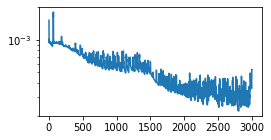

In [22]:
plt.figure(figsize=(4,2))
plt.semilogy(hist['train_loss'])
plt.semilogy(hist['test_loss'])
print(newloss)

In [23]:
model(torch.Tensor(x_train[:10,:])).detach().numpy()

array([[-0.03795546],
       [ 0.00789982],
       [-0.02336927],
       [-0.00646783],
       [-0.07678325],
       [ 0.00509729],
       [-0.0097194 ],
       [-0.02248524],
       [ 0.01817159],
       [-0.00664614]], dtype=float32)

In [24]:
f(x_train[:10,:])

array([-0.05777416,  0.03692896, -0.04655933, -0.05797162, -0.08998838,
        0.00996507, -0.03376938, -0.05769558,  0.03610678, -0.01525079],
      dtype=float32)

##### source from AutoEncoderLike BottleNeck

In [25]:
s_train = model.get_latent_variable(torch.Tensor(x_train)).detach().numpy()

[-26.311268] [23.983776]
[-26.311268, -7.7363853] [23.983776, 11.330512]


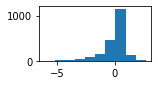

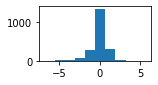

In [26]:
s_mean = []
s_std  = []

for i in range(nsource):
  s_mean.append(s_train[:,i].mean())
  s_std.append(s_train[:,i].std())
  print(s_mean,s_std)
  s_train[:,i] = (s_train[:,i]-s_mean[i])/s_std[i]
  plt.figure(figsize=(2,1))
  plt.hist(s_train[:,i]);

In [27]:
s_test = model.get_latent_variable(torch.Tensor(x_test)).detach().numpy()
for i in range(nsource):
  s_test[:,i] = (s_test[:,i]-s_mean[i])/s_std[i]

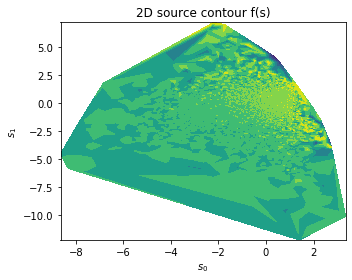

In [28]:
plt.figure(figsize=(5,4))
plt.tricontourf(s_test[:,0],s_test[:,1],y_test.reshape(-1))

plt.title(str(nsource)+'D source contour f(s)')
plt.xlabel(r'$s_0$')
plt.ylabel(r'$s_1$')
plt.tight_layout()
plt.savefig('4Dto2D_source_contour.png',dpi=180)

In [29]:
s_onAxis = model.get_latent_variable(torch.Tensor(x_onAxis)).detach().numpy()
for i in range(nsource):
  s_onAxis[:,i] = (s_onAxis[:,i]-s_mean[i])/s_std[i]

##### GP on source

In [30]:
kernel = C(0.2, (2e-3, 1e2)) * RBF(1, (2e-3, 1e2))
gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=9, alpha=0.1)

In [31]:
gp.score(s_train, y_train), gp.score(s_test, y_test)

(-0.0007719830981252063, -7.479945886368355e-05)

In [32]:
gp.fit(s_train, y_train)
gp.kernel_

0.0447**2 * RBF(length_scale=1.55)

In [33]:
gp.score(s_train, y_train), gp.score(s_test, y_test)   

(0.4308870655629058, -0.19263520092692832)

##### on axis

In [34]:
y_onAxis_GP, sigma_GP = gp.predict(s_onAxis, return_std=True)
y_onAxis_GP = y_onAxis_GP.reshape(-1)
y_onAxis_NN = model(torch.Tensor(x_onAxis)).detach().numpy() 

In [35]:
y_onAxis_NN.shape

(256, 1)

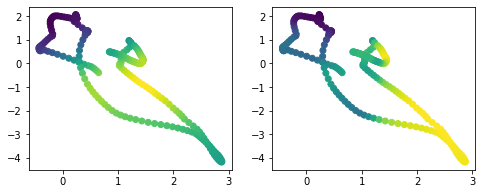

In [36]:
plt.figure(figsize=(8,3))
plt.subplot(1,2,1)
plt.scatter(s_onAxis[:,0],s_onAxis[:,1],c=y_onAxis_GP)
plt.subplot(1,2,2)
plt.scatter(s_onAxis[:,0],s_onAxis[:,1],c=y_onAxis_NN[:,0])

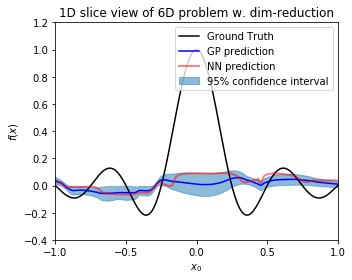

In [37]:
fig = plt.figure(figsize=(5,4))

plt.plot(x_onAxis[:,0],y_onAxis ,'k' , label='Ground Truth')
plt.plot(x_onAxis[:,0],y_onAxis_GP, 'b-', label='GP prediction')
plt.fill_between(x_onAxis[:,0], 
                y_onAxis_GP- 1.96 * sigma_GP,
                y_onAxis_GP+ 1.96 * sigma_GP, 
                label='95% confidence interval', color='C0', alpha=.5, )
plt.plot(x_onAxis[:,0],y_onAxis_NN, 'r-', label='NN prediction',lw=2,alpha=0.5)

plt.title('1D slice view of '+str(ndim)+'D problem w. dim-reduction')
plt.xlabel(r'$x_0$')
plt.ylabel(r'$f(x)$')
plt.legend(loc='upper right')
plt.xlim(-1,1)
plt.ylim(-0.4,1.2)
plt.xticks([-1,-0.5,0,0.5,1])
plt.tight_layout()
plt.savefig('GP_wDimReduct_'+str(ndim)+'D_'+str(nsource)+'source.png',dpi=180)

In [38]:
ptt.count_parameters(model)

15065

### 1D source

In [39]:
nsource = 1

In [ ]:
old_best_loss = 1
for i in range(10):
  model = ptt.resFCNN_autoEncoder([ndim,32,32,nsource],[nsource,16,16,1], torch.nn.CELU(inplace=True), residual=True, identity_block_every_layer=True)
  mode,hist = ptt.train_supervised(model,1.0e-2,200,
                                  train_data_loader,
                                  optimizer=torch.optim.Adam,
#                                   optim_args = {'weight_decay':0.2},
                                  criterion=ptt.MPELoss(p=p),
                                  old_best_loss = old_best_loss,
                                  dispHead = 0, dispTail = 0)
  tmp = test(model,ptt.MPELoss(p=p),train_data_loader)
  if tmp > 1:
    continue
  mode,hist = ptt.train_supervised(model,2.0e-3,1300,
                                  train_data_loader,
                                  optimizer=torch.optim.Adam,
#                                   optim_args = {'weight_decay':0.2},
                                  criterion=ptt.MPELoss(p=p),
                                  old_hist = hist,
                                  old_best_loss = old_best_loss,
                                  dispHead = 0, dispTail = 0)
  newloss = test(model,ptt.MPELoss(p=p),train_data_loader)
  
  if newloss < old_best_loss:
    old_best_loss = newloss
    final_model = copy(model)
    final_hist  = copy(hist)
    
  if newloss < 1e-3:
    break
    
  plt.figure(figsize=(4,2))
  plt.semilogy(hist['train_loss'])
  plt.semilogy(hist['test_loss'])

model = final_model
hist = final_hist
mode,hist = ptt.train_supervised(model,5.0e-4,1500,
                                train_data_loader,
                                optimizer=torch.optim.Adam,
#                                 optim_args = {'weight_decay':0.2},
                                # data_loader,
                                old_hist = hist,
                                criterion=ptt.MPELoss(p=p),
                                old_best_loss = newloss,
                                dispHead = 0, dispTail = 0)
newloss = test(model,ptt.MPELoss(p=p),train_data_loader)


model = model.cpu()
model.eval();

In [ ]:
plt.figure(figsize=(4,2))
plt.semilogy(hist['train_loss'])
print(newloss)

In [ ]:
model(torch.Tensor(x_train[:10,:])).detach().numpy()

In [ ]:
f(x_train[:10,:])

##### source from AutoEncoderLike BottleNeck

In [ ]:
s_train = model.get_latent_variable(torch.Tensor(x_train)).detach().numpy()

In [ ]:
s_mean = []
s_std  = []

for i in range(nsource):
  s_mean.append(s_train[:,i].mean())
  s_std.append(s_train[:,i].std())
  print(s_mean,s_std)
  s_train[:,i] = (s_train[:,i]-s_mean[i])/s_std[i]
  plt.figure(figsize=(2,1))
  plt.hist(s_train[:,i]);

In [ ]:
s_test = model.get_latent_variable(torch.Tensor(x_test)).detach().numpy()
for i in range(nsource):
  s_test[:,i] = (s_test[:,i]-s_mean[i])/s_std[i]

In [ ]:
plt.figure(figsize=(5,4))
plt.scatter(s_test[:,0],y_test.reshape(-1))

plt.title(str(nsource)+'D source vs f(s)')
plt.xlabel(r'$s$')
plt.ylabel(r'$y$')
plt.tight_layout()
plt.savefig('4Dto1D_source_contour.png',dpi=180)

In [ ]:
s_onAxis = model.get_latent_variable(torch.Tensor(x_onAxis)).detach().numpy()
for i in range(nsource):
  s_onAxis[:,i] = (s_onAxis[:,i]-s_mean[i])/s_std[i]

##### GP on source

In [ ]:
kernel = C(0.2, (2e-3, 1e2)) * RBF(1, (2e-3, 1e2))
gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=9, alpha=0.1)

In [ ]:
gp.score(s_train, y_train), gp.score(s_test, y_test)

In [ ]:
gp.fit(s_train, y_train)
gp.kernel_

In [ ]:
gp.score(s_train, y_train), gp.score(s_test, y_test)   

##### on axis

In [ ]:
y_onAxis_GP, sigma_GP = gp.predict(s_onAxis, return_std=True)
y_onAxis_GP = y_onAxis_GP.reshape(-1)
y_onAxis_NN = model(torch.Tensor(x_onAxis)).detach().numpy() 

In [ ]:
y_onAxis_NN.shape

In [ ]:
plt.figure(figsize=(8,3))
plt.subplot(1,2,1)
plt.scatter(s_onAxis[:,0],y_onAxis)
plt.subplot(1,2,2)
plt.scatter(s_onAxis[:,0],y_onAxis_NN)

In [ ]:
fig = plt.figure(figsize=(5,4))

plt.plot(x_onAxis[:,0],y_onAxis ,'k' , label='Ground Truth')
plt.plot(x_onAxis[:,0],y_onAxis_GP, 'b-', label='GP prediction')
plt.fill_between(x_onAxis[:,0], 
                y_onAxis_GP- 1.96 * sigma_GP,
                y_onAxis_GP+ 1.96 * sigma_GP, 
                label='95% confidence interval', color='C0', alpha=.5, )
plt.plot(x_onAxis[:,0],y_onAxis_NN, 'r-', label='NN prediction',lw=2,alpha=0.5)

plt.title('1D slice view of '+str(ndim)+'D problem w. dim-reduction')
plt.xlabel(r'$x_0$')
plt.ylabel(r'$f(x)$')
plt.legend(loc='upper right')
plt.xlim(-1,1)
plt.ylim(-0.4,1.2)
plt.xticks([-1,-0.5,0,0.5,1])
plt.tight_layout()
plt.savefig('GP_wDimReduct_'+str(ndim)+'D_'+str(nsource)+'source.png',dpi=180)

In [ ]:
ptt.count_parameters(model)